In [1]:
import torch
from torch import nn
import torch.optim as optim

import torchtext
import pandas as pd
import numpy as np
import sklearn.metrics
from collections import defaultdict
from tqdm import tqdm

from models import MLP1Base, MLP2Base, MetaMLPModel
from torchmeta.modules import MetaLinear
import scipy.stats

In [2]:
df=pd.read_csv('./parallelograms-revisited/experiment2_data_relational_similarity/mean_relsim_ratings.csv')

In [3]:
y = np.array(df['mean_rating'])

In [4]:
df

,relation1,relation2,comparison_type,pair1_word1,pair1_word2,pair2_word1,pair2_word2,mean_rating,num_ratings
0,3a,3a,within-subtype,candy,sweets,sofa,chair,3.750000,12
1,1a,1a,within-subtype,dollar,currency,wheat,bread,4.727273,11
2,9a,9a,within-subtype,store,shopper,supermarket,groceries,5.583333,12
3,6a,6a,within-subtype,classic,trendy,integrity,dishonest,3.700000,10
4,10a,10a,within-subtype,flashing,caution,green,go,6.583333,12
...,...,...,...,...,...,...,...,...,...
6189,8b,8a,between-subtype,embarrassed,blush,explosion,damage,5.200000,10
6190,1a,2a,between-type,animal,carabao,dog,tail,3.090909,11
6191,5a,7c,between-type,intellectual,professor,police,gun,3.200000,10
6192,8a,8a,within-subtype,education,expertise,showering,cleanliness,4.800000,10


In [5]:
vocab = torchtext.vocab.GloVe(name='840B', dim=300)

In [6]:
meta_linear_params = torch.load('./models/meta_linear.pt', map_location=torch.device('cpu'))
meta_mlp1_params = torch.load('./models/meta_mlp1.pt', map_location=torch.device('cpu'))
meta_mlp2_params = torch.load('./models/meta_mlp2.pt', map_location=torch.device('cpu'))

In [7]:
meta_linear = nn.Linear(in_features=300, out_features=300)
meta_mlp1 = MLP1Base(input_dim=300, hidden_dim=500, output_dim=300)
meta_mlp2 = MLP2Base(input_dim=300, hidden_dim=500, output_dim=300)

In [8]:
meta_linear.weight.data = meta_linear_params['weight']
meta_linear.bias.data = meta_linear_params['bias']

meta_mlp1.l1.weight.data = meta_mlp1_params['features.layer1.linear.weight']
meta_mlp1.l1.bias.data = meta_mlp1_params['features.layer1.linear.bias']
meta_mlp1.l2.weight.data = meta_mlp1_params['classifier.weight']
meta_mlp1.l2.bias.data = meta_mlp1_params['classifier.bias']

meta_mlp2.l1.weight.data = meta_mlp2_params['features.layer1.linear.weight']
meta_mlp2.l1.bias.data = meta_mlp2_params['features.layer1.linear.bias']
meta_mlp2.l2.weight.data = meta_mlp2_params['features.layer2.linear.weight']
meta_mlp2.l2.bias.data = meta_mlp2_params['features.layer2.linear.bias']
meta_mlp2.l3.weight.data = meta_mlp2_params['classifier.weight']
meta_mlp2.l3.bias.data = meta_mlp2_params['classifier.bias']

In [9]:
def get_relsim_scores(df, vocab, get_loss):
    relsim_scores = [0] * len(df)
    
    for idx, row in tqdm(df.iterrows()):
        w1, w2, w3, w4 = row['pair1_word1'], row['pair1_word2'], row['pair2_word1'], row['pair2_word2']

        if w1 not in vocab.stoi or w2 not in vocab.stoi or w3 not in vocab.stoi or w4 not in vocab.stoi:
            continue
            
        a = vocab[w1]
        b = vocab[w2]
        c = vocab[w3]
        d = vocab[w4]
        
        forward = get_loss(a, b, c, d)
        backward = get_loss(c, d, a, b)

        relsim_scores[idx] = np.exp(-forward) - np.exp(-backward)
    return relsim_scores

In [10]:
def get_categorized_relsim_scores(df, vocab, get_loss):
    prediction_dict = defaultdict(lambda: [])
    word_dict = defaultdict(lambda: [])
    
    for idx, row in tqdm(df.iterrows()):
        w1, w2, w3, w4 = row['pair1_word1'], row['pair1_word2'], row['pair2_word1'], row['pair2_word2']

        if w1 not in vocab.stoi or w2 not in vocab.stoi or w3 not in vocab.stoi or w4 not in vocab.stoi:
            continue
            
        category_id = int(row['relation1'][:-1])
        human_score = row['mean_rating']
        word_dict[category_id].append(human_score)
            
        a = vocab[w1]
        b = vocab[w2]
        c = vocab[w3]
        d = vocab[w4]
        
        forward = get_loss(a, b, c, d)
        # backward = get_loss(c, d, a, b)

        prediction_dict[category_id].append(np.exp(-forward))
        
    return prediction_dict, word_dict

In [11]:
def get_categorized_relsim_scores_cos(df, vocab, get_loss):
    prediction_dict = defaultdict(lambda: [])
    word_dict = defaultdict(lambda: [])
    
    for idx, row in tqdm(df.iterrows()):
        w1, w2, w3, w4 = row['pair1_word1'], row['pair1_word2'], row['pair2_word1'], row['pair2_word2']

        if w1 not in vocab.stoi or w2 not in vocab.stoi or w3 not in vocab.stoi or w4 not in vocab.stoi:
            continue
            
        category_id = int(row['relation1'][:-1])
        human_score = row['mean_rating']
        word_dict[category_id].append(human_score)
            
        a = vocab[w1]
        b = vocab[w2]
        c = vocab[w3]
        d = vocab[w4]
        
        loss = get_loss(a, b, c, d)[0][0]
        # print(loss)

        prediction_dict[category_id].append(loss)
        
    return prediction_dict, word_dict

In [23]:
def get_categorized_relsim_scores_eu(df, vocab, get_loss):
    prediction_dict = defaultdict(lambda: [])
    word_dict = defaultdict(lambda: [])
    
    for idx, row in tqdm(df.iterrows()):
        w1, w2, w3, w4 = row['pair1_word1'], row['pair1_word2'], row['pair2_word1'], row['pair2_word2']

        if w1 not in vocab.stoi or w2 not in vocab.stoi or w3 not in vocab.stoi or w4 not in vocab.stoi:
            continue
            
        category_id = int(row['relation1'][:-1])
        human_score = row['mean_rating']
        word_dict[category_id].append(human_score)
            
        a = vocab[w1]
        b = vocab[w2]
        c = vocab[w3]
        d = vocab[w4]
        
        loss = get_loss(a, b, c, d)
        # print(loss)

        prediction_dict[category_id].append(loss)
        
    return prediction_dict, word_dict

In [17]:
mlopt = optim.SGD(meta_linear.parameters(), lr=0.1)
mm1opt = optim.SGD(meta_mlp1.parameters(), lr=0.1)
mm2opt = optim.SGD(meta_mlp2.parameters(), lr=0.1)

mlcache = meta_linear.state_dict()
mm1cache = meta_mlp1.state_dict()
mm2cache = meta_mlp2.state_dict()

criterion = nn.MSELoss()

def get_ml_loss(a, b, c, d):
    meta_linear.load_state_dict(mlcache)
    mlopt.zero_grad()
    a_hat = meta_linear(a)
    loss = criterion(a_hat, b)
    loss.backward()
    mlopt.step()
    c_hat = meta_linear(c)
    loss = criterion(c_hat, d)
    return loss.detach().numpy()

def get_m1_loss(a, b, c, d):
    meta_mlp1.load_state_dict(mm1cache)
    mm1opt.zero_grad()
    a_hat = meta_mlp1(a)
    loss = criterion(a_hat, b)
    loss.backward()
    mm1opt.step()
    c_hat = meta_mlp1(c)
    loss = criterion(c_hat, d)
    return loss.detach().numpy()

def get_m2_loss(a, b, c, d):
    meta_mlp2.load_state_dict(mm2cache)
    mm2opt.zero_grad()
    a_hat = meta_mlp2(a)
    loss = criterion(a_hat, b)
    loss.backward()
    mm2opt.step()
    c_hat = meta_mlp2(c)
    loss = criterion(c_hat, d)
    return loss.detach().numpy()

def cos(a, b, c, d):
    return sklearn.metrics.pairwise.cosine_similarity((a-b).reshape(1, -1), c-d.reshape(1, -1))

def euclid(a, b, c, d):
    r1 = a-b
    r2 = c-d
    return 1-np.linalg.norm(r1-r2)

In [46]:
x_mlp2 = get_relsim_scores(df, vocab, get_m2_loss)

6194it [00:37, 165.09it/s]


In [47]:
scipy.stats.ttest_1samp(x_mlp2, 0)

Ttest_1sampResult(statistic=-11.16124293568011, pvalue=1.182578686948434e-28)

(array([1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 7.950e+02, 5.284e+03,
        9.400e+01, 1.300e+01, 2.000e+00, 3.000e+00]),
 array([-0.66973305, -0.54281398, -0.41589491, -0.28897585, -0.16205678,
        -0.03513771,  0.09178135,  0.21870042,  0.34561949,  0.47253855,
         0.59945762]),
 <a list of 10 Patch objects>)

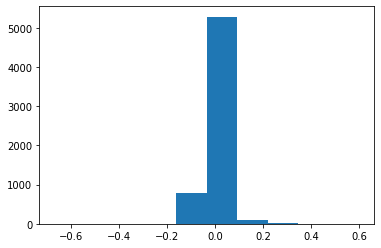

In [17]:
plt.hist(x_mlp2)

In [29]:
for key, val in m2_pred_dict.items():
    print(key, scipy.stats.ttest_1samp(val, 0))

3 Ttest_1sampResult(statistic=5.282182245924276, pvalue=1.7420420478782517e-07)
1 Ttest_1sampResult(statistic=-3.4644513958378784, pvalue=0.0005663455920589758)
9 Ttest_1sampResult(statistic=5.526813218168924, pvalue=4.953641441926146e-08)
6 Ttest_1sampResult(statistic=2.1638531868072315, pvalue=0.030875552163482395)
10 Ttest_1sampResult(statistic=0.9087057888762596, pvalue=0.3638752268584786)
7 Ttest_1sampResult(statistic=1.1898057442745609, pvalue=0.23463056117504716)
5 Ttest_1sampResult(statistic=4.718568857368324, pvalue=2.9732299206119596e-06)
8 Ttest_1sampResult(statistic=0.2935654400354975, pvalue=0.7692011316732361)
4 Ttest_1sampResult(statistic=7.049476409981675, pvalue=4.233932230512787e-12)
2 Ttest_1sampResult(statistic=-3.24590903350662, pvalue=0.0012248724659896736)


In [18]:
m2_pred_dict, m2_word_dict = get_categorized_relsim_scores(df, vocab, get_m2_loss)

6194it [00:22, 273.86it/s]


In [19]:
cos_pred, word_dict = get_categorized_relsim_scores_cos(df, vocab, cos)

6194it [00:03, 1842.85it/s]


In [24]:
eu_predict, word_dict = get_categorized_relsim_scores_eu(df, vocab, euclid)

6194it [00:01, 5869.21it/s]


In [25]:
def get_category_coeffs(word_dict, pred_dict):
    r_list = [0] * (len(word_dict)+1)

    for key, val in word_dict.items():
        pred = pred_dict[key]
        # pred = np.exp(np.array(pred))
        corr, pval = scipy.stats.pearsonr(val, pred)
        r_list[key] = corr
        
    return r_list[1:]

In [26]:
cos_corr = get_category_coeffs(word_dict, cos_pred)
eu_corr = get_category_coeffs(word_dict, eu_predict)
meta_corr = get_category_coeffs(word_dict, m2_pred_dict)

In [27]:
import matplotlib.pyplot as plt

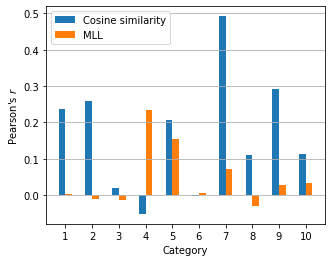

In [29]:
N = 10

fig, ax = plt.subplots(figsize=(5, 4))
ind = np.arange(10)
width = 0.25
p1 = ax.bar(ind, cos_corr, width)
# p2 = ax.bar(ind+width, eu_corr, width)
p3 = ax.bar(ind+width, meta_corr, width)

# ax.set_title("Pearson's $r$ by category")
ax.set_xlabel('Category')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((1, 2, 3, 4, 5, 6, 7, 8, 9, 10))
ax.grid(axis='y')

ax.legend((p1[0], p3[0]), ('Cosine similarity',
                                 'MLL'))
ax.set_ylabel("Pearson's $r$")
ax.autoscale_view()

In [44]:
m2_pred_dict

defaultdict(<function __main__.get_categorized_relsim_scores.<locals>.<lambda>>,
            {3: [0.98655814,
              0.941946,
              0.9388296,
              0.94199586,
              0.9536079,
              0.9697966,
              0.9696293,
              0.9634723,
              0.9499496,
              0.97382104,
              0.8981765,
              0.98562884,
              0.93505514,
              0.950149,
              0.95741415,
              0.9490934,
              0.9466572,
              0.941598,
              0.9681781,
              0.94008565,
              0.9599085,
              0.9641662,
              0.94955033,
              0.9852028,
              0.94567925,
              0.9687702,
              0.9410687,
              0.9188734,
              0.87567645,
              0.92610884,
              0.95452434,
              0.9493703,
              0.94008934,
              0.9465856,
              0.95807004,
              0.94599384,
    